# ML Hotel Project - Team Indecision Tree

## Problem Statement
Given extensive information on around 120000 hotel bookings, create a binary classification model to predict whether a booking will be cancelled. In the case of cancelled bookings, predict how many days in advance the guest cancels

## The Code

### Necessary Imports

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn import svm
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc, classification_report
from numpy.typing import ArrayLike
from typing import List
import math
from utility import *
import pickle as pkl

%matplotlib inline

### Reading data

In [97]:
data = pd.read_csv('data.csv')

### Exploratory Data Analysis

In [98]:
#Histogram between country and cancellation
ratio = {}

for i in data['country'].unique():
    if not isinstance(i, float) and len(data[data['country']==i]) >= 100:
        ratio[i] = len(data[(data['country']==i) & (data['is_canceled']==1)]) / len(data[data['country']==i])
    
sorted_country_cancellation = sorted(ratio.items(), key=lambda x:x[1])[::-1]
ratio = dict(sorted_country_cancellation)
# print(ratio)

reqd_df = pd.DataFrame({"country": ratio.keys(), "Cancellation ratio": ratio.values()})
fig = px.bar(reqd_df, x="country", y="Cancellation ratio", width=1000)
fig.update_traces(width=0.5)
fig.show()

In [99]:
years = data['arrival_date_year'].unique().tolist()
years.sort()
x_ticks = []
booking_counts = []
cancellation_counts = []
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
for year in years:
    for month in months:
        x_ticks.append(month + " " + str(year))
        booking_counts.append(len(data[(data['arrival_date_year'] == year) & (data['arrival_date_month'] == month)]))
        cancellation_counts.append(len(data[(data['arrival_date_year'] == year) & (data['arrival_date_month'] == month) & (data['is_canceled'] == 1)]))

# Removing time periods that are out of range of the data
x_ticks = x_ticks[6:-4]
booking_counts = booking_counts[6:-4]
cancellation_counts = cancellation_counts[6:-4]

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x_ticks, 
        y=booking_counts, 
        name="Bookings"
    )
)
fig.add_trace(
    go.Scatter(
        x=x_ticks, 
        y=cancellation_counts, 
        name="Cancellations"
    )
)
fig.update_layout(
    title="Booking and Cancellation Counts over Time", 
    xaxis_title="Time", 
    yaxis_title="Count"
)
fig.show()


It can be seen from the above graph that the cancellations line maintains a similar trend as the bookings line. This means that the proportion of cancellations has remained more or less the same throughout the time period.

In [100]:
hotels = data['hotel'].unique()
booking_counts = []
cancellation_counts = []
for hotel in hotels:
    booking_counts.append(len(data[(data['hotel'] == hotel)]))
    cancellation_counts.append(len(data[(data['hotel'] == hotel) & (data['is_canceled'] == 1)]))

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=hotels,
        y=booking_counts,
        name="Bookings",
        width=0.5
    )
)
fig.add_trace(
    go.Bar(
        x=hotels,
        y=cancellation_counts,
        name="Cancellations",
        width=0.3
    )
)

fig.update_layout(
    title="Booking and Cancellation Counts against Hotel", 
    xaxis_title="Hotel", 
    yaxis_title="Count",
    barmode="overlay"
)
fig.show()


Total bookings in the given time period of a City Hotel is nearly twice as that of Resort Hotel.
Cancellation rate of City Hotel bookings is approx. 1.5 times as that of the Resort Hotel bookings.


In [101]:
# Sunburst graph
fig = px.sunburst(data, path=['deposit_type', 'is_canceled'], labels=["a","b","a","b","c","d"])
for i in range(len(fig.data[0].labels)):
    if(fig.data[0].labels[i] == '0'):
        fig.data[0].labels[i] = 'Not Canceled'
    if(fig.data[0].labels[i] == '1'):
        fig.data[0].labels[i] = 'Canceled'
fig.update_traces(textinfo="label+percent parent")
fig.show()

The plot above depicts the cancellations by deposit types. Bookings with refundable deposits are a very small percentage of the total bookings

In [102]:
#Histogram between No. of special requests and cancellation
ratio = {}

for i in data['total_of_special_requests'].unique():
    ratio[i] = len(data[(data['total_of_special_requests']==i) & (data['is_canceled']==1)]) / len(data[data['total_of_special_requests']==i])

reqd_df = pd.DataFrame({"total_of_special_requests": ratio.keys(), "Cancellation ratio": ratio.values()})
fig = px.bar(reqd_df, x="total_of_special_requests", y="Cancellation ratio", width=1000, labels={'total_of_special_requests':'Total No. of Special Requests'})
fig.update_traces(width=0.5)
fig.show()

In [103]:
fig = px.sunburst(data, path=['market_segment', 'is_canceled'])
for i in range(len(fig.data[0].labels)):
    if(fig.data[0].labels[i] == '0'):
        fig.data[0].labels[i] = 'Not Canceled'
    if(fig.data[0].labels[i] == '1'):
        fig.data[0].labels[i] = 'Canceled'
fig.show()

### Preprocessing

#### Pipeline

In [104]:
pipeline = make_pipeline(
    FunctionTransformer(DataImputer(column_to_value={"children":0})),
    FunctionTransformer(ArrivalDateTransformer()),
    FunctionTransformer(ColumnRemover(['country','agent','company','month','day','distribution_channel'])),
    FunctionTransformer(RoomTypeTransformer()),
    FunctionTransformer(MealTypeTransformer()),
    FunctionTransformer(UncleanDataPointsRemover()),
    FunctionTransformer(CancellationsDaysInserter()),
    FunctionTransformer(ColumnRemover(['reservation_status','reservation_status_date','arrival_date']))
)

pipeline.fit_transform(data)

,hotel,is_canceled,lead_time,year,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reserved_assigned_match,cancellation_days
2,Resort Hotel,0,7,2015,27,0,1,1,0.0,0,...,0,0,No Deposit,0,Transient,75.00,0,0,1,-1
3,Resort Hotel,0,13,2015,27,0,1,1,0.0,0,...,0,0,No Deposit,0,Transient,75.00,0,0,0,-1
4,Resort Hotel,0,14,2015,27,0,2,2,0.0,0,...,0,0,No Deposit,0,Transient,98.00,0,1,0,-2
5,Resort Hotel,0,14,2015,27,0,2,2,0.0,0,...,0,0,No Deposit,0,Transient,98.00,0,1,0,-2
6,Resort Hotel,0,0,2015,27,0,2,2,0.0,0,...,0,0,No Deposit,0,Transient,107.00,0,0,0,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,35,2,5,2,0.0,0,...,0,0,No Deposit,0,Transient,96.14,0,0,0,-7
119386,City Hotel,0,102,2017,35,2,5,3,0.0,0,...,0,0,No Deposit,0,Transient,225.43,0,2,0,-7
119387,City Hotel,0,34,2017,35,2,5,2,0.0,0,...,0,0,No Deposit,0,Transient,157.71,0,4,0,-7
119388,City Hotel,0,109,2017,35,2,5,2,0.0,0,...,0,0,No Deposit,0,Transient,104.40,0,0,0,-7


#### Data Splitting

In [105]:
# Splitting data into train and test sets (80% train, 20% test)
data_train_and_validation, data_test = train_test_split(data, test_size=0.2, stratify=data['is_canceled'])

# Splitting data into features and label for classification
X_train_and_validation = data_train_and_validation.drop(['is_canceled','cancellation_days'], axis='columns')
y_train_and_validation = data_train_and_validation.is_canceled

X_test = data_test.drop(['is_canceled','cancellation_days'], axis='columns')
y_test = data_test.is_canceled

# Regression 
X_train_and_validation_reg = data_train_and_validation[data_train_and_validation['is_canceled']==1]
X_train_and_validation_reg = X_train_and_validation_reg.drop(['is_canceled','cancellation_days'], axis='columns')
y_train_and_validation_reg = data_train_and_validation[data_train_and_validation['is_canceled']==1]
y_train_and_validation_reg = y_train_and_validation_reg.cancellation_days

X_test_reg = data_test[data_test['is_canceled']==1]
X_test_reg = X_test_reg.drop(['is_canceled','cancellation_days'], axis='columns')
y_test_reg = data_test[data_test['is_canceled']==1]
y_test_reg = y_test_reg.cancellation_days

In [106]:
# For the entire dataset
# Splitting data into features and label for classification
X_data = data.drop(['is_canceled','cancellation_days'], axis='columns')
X_data_reg = data[data['is_canceled']==1]
X_data_reg = data.drop(['is_canceled','cancellation_days'], axis='columns')

y_data = data.is_canceled
y_data_reg = data[data['is_canceled']==1]
y_data_reg = data.cancellation_days

### Classification

### Regression
We tried with SVM and Logistic Regression models and finalized SVM because we were getting better results for it

In [107]:
features = X_train_and_validation.columns

#### SVM

Defining the model below

In [118]:
def get_SVM_classifier(features):
    
    # Deposit Type, Customer Type, Hotel and Market Segment will be one hot encoded
    categorical_features = list(
        set(features) & set(
            [
                'deposit_type',
                'customer_type',
                'hotel',
                'market_segment',
            ]
        )
    )
    numerical_features = list(set(features) - set(categorical_features))

    columnTransformer = ColumnTransformer(
        transformers = [
            (
                'categorical', OneHotEncoder(
                    handle_unknown="ignore"
                ), 
                categorical_features
            ),
            (
                'numerical', 
                StandardScaler(), 
                numerical_features
            )
        ]
    )

    classifier = make_pipeline(
        columnTransformer,
        svm.SVC(probability=True)
    )
    
    return classifier

##### Performing hyperparameter tuning:

C -  essentially a regularisation parameter, which controls the trade-off between achieving a hyperplane with the largest minimum margin, and a hyperplane that correctly separates as many instances as possible. We decided to check with the values 1, 20 and 100. 

Kernel - Linear and RBF

RandomizedSearchCV instead of GridSearchCV to minimize compute time and due to resource constraints. Trying 2 iterations on the any of the combinations above to equip our model with the best hyperparameter with a k-cross-fold of value 5


In [46]:
pipeline = get_SVM_classifier(features)

param_grid = [
    {
        'svc__C':[1,20,100],
        'svc__kernel':['linear', 'rbf']
    }
]

grid_pipeline = RandomizedSearchCV(pipeline, param_grid, cv=5, n_iter=2, verbose=100, return_train_score = False)
grid_pipeline.fit(X=X_train_and_validation, y=y_train_and_validation)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START svc__C=1, svc__kernel=linear................................


KeyboardInterrupt: 

In [50]:
pd.DataFrame(grid_pipeline.cv_results_)[['param_svc__kernel','param_svc__C','mean_test_score','rank_test_score']]

NameError: name 'grid_pipeline' is not defined

In [ ]:
pkl.dump(grid_pipeline,open("svm_randomized.p","wb"))

In [ ]:
best_params = grid_pipeline.best_params_
best_model = grid_pipeline.best_estimator_
predictions = best_model.predict(X_test)
plot_confusion_matrix(y_test, predictions)
print("Best Score: ", grid_pipeline.best_score_)

##### Plotting ROC Curve

In [ ]:
y_train_pred = best_model.decision_function(X_train_and_validation)    
y_test_pred = best_model.decision_function(X_test) 
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_and_validation, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Cancelled", "Not Cancelled"]
print(classification_report(y_test, predictions, target_names=target_names))

#### Logistic Regression Model

Defining the model below

In [108]:
def get_LR_classifier(features):
    
    # Deposit Type, Customer Type, Hotel and Market Segment will be one hot encoded
    categorical_features = list(
        set(features) & set(
            [
                'deposit_type',
                'customer_type',
                'hotel',
                'market_segment',
            ]
        )
    )
    numerical_features = list(set(features) - set(categorical_features))

    columnTransformer = ColumnTransformer(
        transformers = [
            (
                'categorical', 
                OneHotEncoder(
                    handle_unknown="ignore"
                ),
                categorical_features
            ),
            (
                'numerical',
                StandardScaler(),
                numerical_features
            )
        ]
    )

    classifier = make_pipeline(
        columnTransformer,
        LogisticRegression(
            max_iter=100000
        )
    )
    
    return classifier


##### Feature Selection by Backward Enumeration 
This gave us features that did not result in good predictions and so we decided to not use it

In [109]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
class Solution:
    features: List[int]
    mse: float

    def __init__(self, y: ArrayLike):
        self.features = list()
        self.mse = mean_squared_error(y, [y.mean()]*len(y))

    def update(self, features: List[int], mse: float) -> bool:
        if(mse < self.mse):
            print(', '.join(str(x) for x in features))
            print(f"\tNew Error: {mse:.3f} better than {self.mse:.3f}")
            self.features = features
            self.mse = mse
            return True

        return False
all_features = features
current_features = all_features
best = Solution(y_train_and_validation)
while len(current_features)>0:
    selected_feature = None

    for feature in current_features:
        new_features = current_features.drop(feature)
        Xr = X_train_and_validation[new_features]
        mses = cross_val_score(estimator=get_LR_classifier(new_features), X=Xr, y=y_train_and_validation, cv=kfold, scoring="neg_mean_squared_error")
        mse = -np.average(mses)

        if(best.update(features=new_features, mse=mse)):
            selected_feature = feature
        
    if(selected_feature):
        current_features = current_features.drop(selected_feature)
    else:
        break
best_features = list(best.features)

lead_time, year, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, market_segment, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, booking_changes, deposit_type, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reserved_assigned_match
	New Error: 0.188 better than 0.234
hotel, lead_time, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, market_segment, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, booking_changes, deposit_type, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reserved_assigned_match
	New Error: 0.187 better than 0.188
hotel, lead_time, year, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, market_segment, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, b

KeyboardInterrupt: 

##### Performing hyperparameter tuning:

C -  essentially a regularisation parameter, which controls the trade-off between achieving a hyperplane with the largest minimum margin, and a hyperplane that correctly separates as many instances as possible. We decided to check with the values 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000. 

Solver - Newton-cg, lbfgs and liblinear

In [112]:
pipeline = get_LR_classifier(features)

param_grid = [
    {
        'logisticregression__C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear']
    }
]

grid_pipeline = GridSearchCV(pipeline,param_grid)
grid_pipeline.fit(X=X_train_and_validation, y=y_train_and_validation)


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['deposit_type',
                                                                          'customer_type',
                                                                          'market_segment',
                                                                          'hotel']),
                                                                        ('numerical',
                                                                         StandardScaler(),
                                                                         ['reserved_assigned_match',
                                                                          'adr',
                                                                          'arrival_date_week_number',
                                                                          'stays_in_week_nights',
                                                                          'previous_cancellations',
                                                                          'total_...
                                                                          'required_car_parking_spaces',
                                                                          'meal',
                                                                          'year',
                                                                          'previous_bookings_not_canceled',
                                                                          'adults',
                                                                          'children',
                                                                          'days_in_waiting_list',
                                                                          'booking_changes',
                                                                          'babies'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=100000))]),
             param_grid=[{'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                    10, 100, 1000, 10000],
                          'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                         'liblinear']}])

In [113]:
best_logistic_regression_params = grid_pipeline.best_params_
best_logistic_regression_model = grid_pipeline.best_estimator_
predictions = best_logistic_regression_model.predict(X_test)
plot_confusion_matrix(y_test, predictions)
print("Best Score: ", grid_pipeline.best_score_)

Best Score:  0.8126552380011539


In [115]:
grid_pipeline.best_estimator_.fit(X_data,y_data)
pkl.dump(grid_pipeline.best_estimator_,open("logistic_regression.p","wb"))

##### Plotting ROC Curve

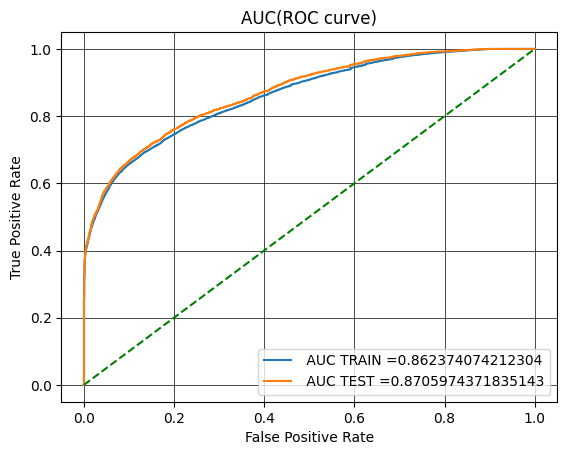

In [116]:
y_train_pred = best_logistic_regression_model.decision_function(X_train_and_validation)    
y_test_pred = best_logistic_regression_model.decision_function(X_test) 
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_and_validation, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [117]:
from sklearn.metrics import classification_report
target_names = ["Cancelled", "Not Cancelled"]
print(classification_report(y_test, predictions, target_names=target_names))

               precision    recall  f1-score   support

    Cancelled       0.81      0.93      0.86     14817
Not Cancelled       0.84      0.63      0.72      8838

     accuracy                           0.82     23655
    macro avg       0.82      0.78      0.79     23655
 weighted avg       0.82      0.82      0.81     23655



### Regression
We tried with simple linear regression, Lasso and Ridge Regularization and finalized Ridge because we were getting similar results with all three of them and Ridge was faster.

In [23]:
features = X_train_and_validation_reg.columns

In [24]:
def get_regressor(features, type):
    # Deposit Type, Customer Type, Hotel and Market Segment will be one hot encoded
    categorical_features = list(set(features) & set([
        'deposit_type',
        'customer_type',
        'hotel',
        'market_segment',
    ]))
    numerical_features = list(set(features) - set(categorical_features))

    columnTransformer = ColumnTransformer(
        transformers = [
            ('categorical', OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ('numerical', StandardScaler(), numerical_features)
        ]
    )

    regressor = make_pipeline(
        columnTransformer,
        type
    )
    
    return regressor

#### Feature Selection by Backward Enumeration 
This gave us features that did not result in good predictions and so we decided to not use it

In [25]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
class Solution:
    features: List[int]
    mse: float

    def __init__(self, y: ArrayLike):
        self.features = list()
        self.mse = mean_squared_error(y, [y.mean()]*len(y))

    def update(self, features: List[int], mse: float) -> bool:
        if(mse < self.mse):
            print(', '.join(str(x) for x in features))
            print(f"\tNew Error: {mse:.3f} better than {self.mse:.3f}")
            self.features = features
            self.mse = mse
            return True

        return False
all_features = features
current_features = all_features
best = Solution(y_train_and_validation_reg)
while len(current_features)>0:
    selected_feature = None

    for feature in current_features:
        new_features = current_features.drop(feature)
        Xr = X_train_and_validation_reg[new_features]
        mses = cross_val_score(estimator=get_regressor(new_features, Ridge()), X=Xr, y=y_train_and_validation_reg, cv=kfold, scoring="neg_mean_squared_error")
        mse = -np.average(mses)

        if(best.update(features=new_features, mse=mse)):
            selected_feature = feature
        
    if(selected_feature):
        current_features = current_features.drop(selected_feature)
    else:
        break
best_features = list(best.features)

lead_time, year, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, meal, market_segment, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, booking_changes, deposit_type, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reserved_assigned_match
	New Error: 3232.268 better than 8224.577
hotel, lead_time, year, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, children, babies, meal, market_segment, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, booking_changes, deposit_type, days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reserved_assigned_match
	New Error: 3231.652 better than 3232.268
hotel, lead_time, year, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, adults, children, babies, market_segment, is_repeated_guest, previous_cancellations, pre

#### Grid Search

In [27]:
lasso_alpha = np.logspace(start=-3, stop=0, num=20)
ridge_alpha = np.logspace(start=-1, stop=2, num=20)

In [28]:
linear_regression_estimator=get_regressor(features,LinearRegression())

lasso_cv = GridSearchCV(
    estimator=get_regressor(features,Lasso(max_iter=10000)),
    param_grid={
        'lasso__alpha': lasso_alpha
    },
    cv=5,
    scoring='neg_mean_squared_error')

ridge_cv = GridSearchCV(
    estimator=get_regressor(features,Ridge()),
    param_grid={
        'ridge__alpha': ridge_alpha
    },
    cv=5,
    scoring='neg_mean_squared_error')

In [29]:
linear_regression_estimator.fit(X_train_and_validation_reg, y_train_and_validation_reg)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['customer_type',
                                                   'deposit_type',
                                                   'market_segment', 'hotel']),
                                                 ('numerical', StandardScaler(),
                                                  ['total_of_special_requests',
                                                   'reserved_assigned_match',
                                                   'is_repeated_guest',
                                                   'lead_time',
                                                   'required_car_parking_spaces',
                                                   'year', 'booking_changes',
                                                   'adr', 'meal',
                                                   'stays_in_week_nights',
                                                   'previous_bookings_not_canceled',
                                                   'arrival_date_week_number',
                                                   'previous_cancellations',
                                                   'stays_in_weekend_nights',
                                                   'adults', 'babies',
                                                   'days_in_waiting_list',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [30]:
lasso_cv.fit(X_train_and_validation_reg, y_train_and_validation_reg)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['customer_type',
                                                                          'deposit_type',
                                                                          'market_segment',
                                                                          'hotel']),
                                                                        ('numerical',
                                                                         StandardScaler(),
                                                                         ['total_of_special_requests',
                                                                          'reserved_assigned_match',
                                                                          'is_repeated_guest',
                                                                          'lead_time',
                                                                          'required_car_parking_s...
                                                                          'babies',
                                                                          'days_in_waiting_list',
                                                                          'children'])])),
                                       ('lasso', Lasso(max_iter=10000))]),
             param_grid={'lasso__alpha': array([0.001     , 0.00143845, 0.00206914, 0.00297635, 0.00428133,
       0.00615848, 0.00885867, 0.01274275, 0.01832981, 0.02636651,
       0.0379269 , 0.05455595, 0.078476  , 0.11288379, 0.16237767,
       0.23357215, 0.33598183, 0.48329302, 0.6951928 , 1.        ])},
             scoring='neg_mean_squared_error')

In [31]:
ridge_cv.fit(X_train_and_validation_reg, y_train_and_validation_reg)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['customer_type',
                                                                          'deposit_type',
                                                                          'market_segment',
                                                                          'hotel']),
                                                                        ('numerical',
                                                                         StandardScaler(),
                                                                         ['total_of_special_requests',
                                                                          'reserved_assigned_match',
                                                                          'is_repeated_guest',
                                                                          'lead_time',
                                                                          'required_car_parking_s...
                                                                          'adults',
                                                                          'babies',
                                                                          'days_in_waiting_list',
                                                                          'children'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59818286,  48.32930239,  69.51927962, 100.        ])},
             scoring='neg_mean_squared_error')

In [32]:
# R2 with training data
print("R2 with training data: ",r2_score(y_train_and_validation_reg, lasso_cv.predict(X_train_and_validation_reg)))
print("Mean Squared Error: ", math.sqrt(mean_squared_error(y_train_and_validation_reg, lasso_cv.predict(X_train_and_validation_reg))))

# R2 with testing data
print("R2 with testing data",r2_score(y_test_reg, lasso_cv.predict(X_test_reg)))
print("Mean Squared Error: ", math.sqrt(mean_squared_error(y_test_reg, lasso_cv.predict(X_test_reg))))


R2 with training data:  0.606362743149756
Mean Squared Error:  56.90847117699435
R2 with testing data 0.6133914738021796
Mean Squared Error:  56.375631265381195


In [33]:
# R2 with training data
print("R2 with training data: ",r2_score(y_train_and_validation_reg, ridge_cv.predict(X_train_and_validation_reg)))
print("Mean Squared Error: ", math.sqrt(mean_squared_error(y_train_and_validation_reg, ridge_cv.predict(X_train_and_validation_reg))))

# R2 with testing data
print("R2 with testing data",r2_score(y_test_reg, ridge_cv.predict(X_test_reg)))
print("Mean Squared Error: ", math.sqrt(mean_squared_error(y_test_reg, ridge_cv.predict(X_test_reg))))

R2 with training data:  0.6063499176823589
Mean Squared Error:  56.90939826377778
R2 with testing data 0.6133818678249101
Mean Squared Error:  56.376331637504336


In [34]:
# R2 with training data
print("R2 with training data: ",r2_score(y_train_and_validation_reg, linear_regression_estimator.predict(X_train_and_validation_reg)))
print("Mean Squared Error: ", math.sqrt(mean_squared_error(y_train_and_validation_reg, linear_regression_estimator.predict(X_train_and_validation_reg))))

# R2 with testing data
print("R2 with testing data",r2_score(y_test_reg, linear_regression_estimator.predict(X_test_reg)))
print("Mean Squared Error: ", math.sqrt(mean_squared_error(y_test_reg, linear_regression_estimator.predict(X_test_reg))))


R2 with training data:  0.6063649123123604
Mean Squared Error:  56.90831437794209
R2 with testing data 0.6132852349122409
Mean Squared Error:  56.38337666243853


In [36]:
ridge_cv.best_estimator_.fit(X_data_reg,y_data_reg)
pkl.dump(ridge_cv.best_estimator_,open("regression.p","wb"))

#### Polynomial regression
We are not using this model since we acheive better results with the linear regression model

In [37]:
def get_poly_regressor(features):
    # Deposit Type, Customer Type, Hotel and Market Segment will be one hot encoded
    categorical_features = list(set(features) & set([
        'deposit_type',
        'customer_type',
        'hotel',
        'market_segment',
    ]))
    numerical_features = list(set(features) - set(categorical_features))

    columnTransformer = ColumnTransformer(
        transformers = [
            ('categorial', OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ('numerical', StandardScaler(), numerical_features)
        ]
    )

    poly_regressor = make_pipeline(
        columnTransformer,
        PolynomialFeatures(degree= 2),
        LinearRegression(),
            
    )
    
    return poly_regressor

In [38]:
poly_regressor = get_poly_regressor(features)
poly_regressor.fit(X_train_and_validation_reg, y_train_and_validation_reg)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorial',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['customer_type',
                                                   'deposit_type',
                                                   'market_segment', 'hotel']),
                                                 ('numerical', StandardScaler(),
                                                  ['total_of_special_requests',
                                                   'reserved_assigned_match',
                                                   'is_repeated_guest',
                                                   'lead_time',
                                                   'required_car_parking_spaces',
                                                   'year', 'booking_changes',
                                                   'adr', 'meal',
                                                   'stays_in_week_nights',
                                                   'previous_bookings_not_canceled',
                                                   'arrival_date_week_number',
                                                   'previous_cancellations',
                                                   'stays_in_weekend_nights',
                                                   'adults', 'babies',
                                                   'days_in_waiting_list',
                                                   'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [39]:
# R2 with training data
print("R2 with training data: ",r2_score(y_train_and_validation_reg, poly_regressor.predict(X_train_and_validation_reg)))
print("Mean Squared Error: ", math.sqrt(mean_squared_error(y_train_and_validation_reg, poly_regressor.predict(X_train_and_validation_reg))))

# R2 with testing data
print("R2 with testing data",r2_score(y_test_reg, poly_regressor.predict(X_test_reg)))
print("Mean Squared Error: ", math.sqrt(mean_squared_error(y_test_reg, poly_regressor.predict(X_test_reg))))


R2 with training data:  0.7065775831839547
Mean Squared Error:  49.133246948357424
R2 with testing data -1.4268101731494755e+17
Mean Squared Error:  34248282936.315517
